# Практическое занятие 3

## Медицинское исследование: гипотеза, получение данных.  Генерация синтетических данных. Подготовка данных к анализу.

### Перед тем, как начать программировать, нам нужно выдвинуть научную гипотезу и проговорить, ЧТО мы хотим сделать

Иначе, эпидемиолог или заказчик, сделает предположение, что вы, сначала "помучали" данные, а потом, найдя, возможно, случайным образом, какие-то закономерности - предлагаете решение.
Хотя такой подход, в некоторых случаях, имеет право на жизнь, но, чаще всего, такой проект, будет забракован на стадии презентации.

---

**Научная гипотеза**

---

У нас есть данные с пациентами, пролеченными от коронавирусной инфекции (не только). Вирусная инфекция не требует назначения антибактериальной терапии, однако, нередки осложения в виде присоединения бактериального компонента.
Назначение антибиотиков может происходить на основании клинических данных, говорящих о том, что у пациента есть бактериальное осложнение, либо, используя лабораторный тест прокальцитонин. При повышении уровня прокальцитонина выше 0.5 - антимикробные препараты показаны.
Однако, этот лабораторный тест, не всегда доступен. В таком случае, врачом используется стратегия: если я не знаю есть или нет бактериального осложениния, я лучше назначу антибиотик, т.е. если я его назначу, когда микробов нет - особо ничего страшного; а если я не назнау антибиотик, когда он нужен - последствия будут плохие.
Таким образом, в некоторых больницах, при отсутствии прокальцитонина, уровень назначения антибиотиков у пациентов с коронавирусной инфекцией достигает 95 %, хотя, согласно исследованиям, нуждаются в этих препаратах около 15 % пациентов.
[Статья (необязательно)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7286278/)



> **Можем ли мы построить модель, предсказывающую показания к антибактериальной терапии, на основе данных эпикризов со значением прокальцитонина? (это и вопрос и гипотеза) **







## Медицинское обоснование и гипотеза сформирована, можно приступить к подготовке данных к выполнению исследования

Данный запрос на первый взгляд может показаться сложным и непонятным.
Суть его в том, что мы собираем все лабораторные значения и заболевания "вокруг" прокальцитонина (в какой-то мере, это можно назвать бутстрапированием), попутно "обогощая" данные положительным классом
(просто copy+paste)

```
-- procalcitonine  - concept_id - 27
-- шаг 1 - соберём всех пациентов с анализами прокальцитонина и в случае если нет значения - заменим значением 0.9
with proc as (select person_id, coalesce(value,  0.9) as value, measurement_date from gb_rwd.measurement m where measurement_concept_id  = 27),
fibr as (select person_id, coalesce(value,  4.9) as value, measurement_date from gb_rwd.measurement m where measurement_concept_id  = 6),
creat as (select person_id, coalesce(value,  109) as value, measurement_date from gb_rwd.measurement m where measurement_concept_id  = 7),
wbc as (select person_id, coalesce(value,  4.9) as value, measurement_date from gb_rwd.measurement m where measurement_concept_id  = 8),
hb as (select person_id, coalesce(value,  120) as value, measurement_date from gb_rwd.measurement m where measurement_concept_id  = 9),
plt as (select person_id, coalesce(value,  155) as value, measurement_date from gb_rwd.measurement m where measurement_concept_id  = 10),
crp as (select person_id, coalesce(value,  24) as value, measurement_date from gb_rwd.measurement m where measurement_concept_id  = 11),
esr as (select person_id, coalesce(value,  50) as value, measurement_date from gb_rwd.measurement m where measurement_concept_id  = 12),
lymph as (select person_id, coalesce(value,  20) as value, measurement_date from gb_rwd.measurement m where measurement_concept_id  = 13),
summ_measurement as (
select distinct proc.person_id as person_id, proc.measurement_date, proc.value procalcitonine, fibr.value fibrinogen,creat.value creatinine, wbc.value wbc,hb.value hb,plt.value plt,crp.value crp,
esr.value esr,lymph.value lymph from proc
left join fibr on proc.person_id = fibr.person_id and fibr.measurement_date  between proc.measurement_date - 3 and proc.measurement_date + 3
left join creat on proc.person_id = creat.person_id and creat.measurement_date  between proc.measurement_date - 3 and proc.measurement_date + 3
left join wbc on proc.person_id = wbc.person_id and wbc.measurement_date  between proc.measurement_date - 3 and proc.measurement_date + 3
left join hb on proc.person_id = hb.person_id and hb.measurement_date  between proc.measurement_date - 3 and proc.measurement_date + 3
left join plt on proc.person_id = plt.person_id and plt.measurement_date  between proc.measurement_date - 3 and proc.measurement_date + 3
left join crp on proc.person_id = crp.person_id and crp.measurement_date  between proc.measurement_date - 3 and proc.measurement_date + 3
left join esr on proc.person_id = esr.person_id and esr.measurement_date  between proc.measurement_date - 3 and proc.measurement_date + 3
left join lymph on proc.person_id = lymph.person_id and lymph.measurement_date  between proc.measurement_date - 3 and proc.measurement_date + 3),
-- Шаг 2 - собрать болезни
pneumonia as (select person_id from gb_rwd."condition" where condition_concept_id = 1),
ihd as (select person_id from gb_rwd."condition" where condition_concept_id = 2),
dm as (select person_id from gb_rwd."condition" where condition_concept_id = 3),
covid as (select person_id from gb_rwd."condition" where condition_concept_id = 4),
ah as (select person_id from gb_rwd."condition" where condition_concept_id = 5),
-- Шаг 3 - создать результат путём объединения временных таблиц
 final_ as (select distinct sm.*, case when pneumonia.person_id is not null then 1 else 0 end as  pneumonia, case when ihd.person_id  is not null then 1 else 0 end as ihd,
case when dm.person_id  is not null  then 1 else  0 end as  dm, case when covid.person_id  is not null then 1 else 0 end as covid,  case when ah.person_id  is
not null then  1 else  0 end as ah
from summ_measurement sm
left join pneumonia on sm.person_id = pneumonia.person_id
left join ihd  on sm.person_id = ihd.person_id
left join dm  on sm.person_id = dm.person_id
left join covid on sm.person_id = covid.person_id
left join ah on sm.person_id = ah.person_id)

select f.*, v.concept_name sex, p.hospital_days len ,  date_of_birth, date_of_birth from final_ f
join gb_rwd.person p on p."person_id " = f.person_id
join gb_rwd.vocabulary v on p."sex_concept_id " = concept_id




```

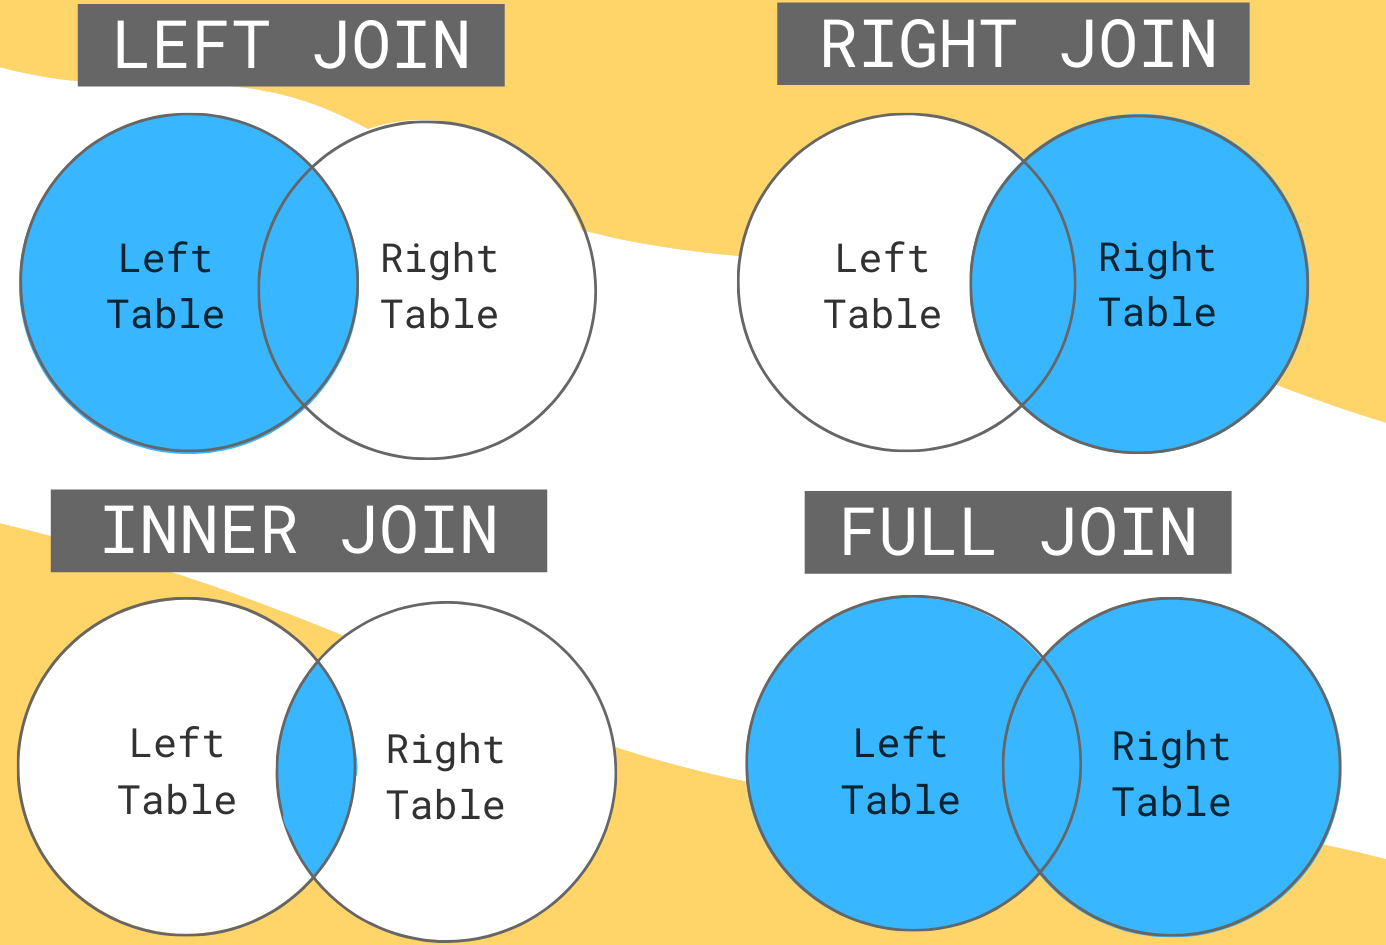

Но всё не совсем так...

Импорт необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
import re

Загрузим подготовеленные данные

In [2]:
study_data =  read_csv('consolidated_data.csv')

In [3]:
data_ = study_data.drop_duplicates()
data_.shape

(72827, 20)

In [4]:
data_.head()

,person_id,measurement_date,procalcitonine,fibrinogen,creatinine,wbc,hb,plt,crp,esr,lymph,pneumonia,ihd,dm,covid,ah,sex,len,date_of_birth,date_of_birth.1
0,1068,2020-12-16,0.20,6.38,70.0,2.90,128.0,175.0,2.6,13.0,9.0,1,0,0,1,0,Женский,17,1952-07-28,1952-07-28
1,1068,2020-12-14,0.27,6.38,70.0,2.90,128.0,175.0,2.6,13.0,9.0,1,0,0,1,0,Женский,17,1952-07-28,1952-07-28
2,1073,2020-12-18,0.09,NaN,67.0,8.09,158.0,445.0,NaN,8.0,18.0,1,1,0,1,0,Женский,11,1959-02-05,1959-02-05
3,1073,2020-12-18,0.09,NaN,67.0,8.09,158.0,395.0,NaN,8.0,18.0,1,1,0,1,0,Женский,11,1959-02-05,1959-02-05
4,1073,2020-12-18,0.09,NaN,67.0,8.09,152.0,445.0,NaN,8.0,18.0,1,1,0,1,0,Женский,11,1959-02-05,1959-02-05


In [5]:
data_['need'] = data_.procalcitonine > 0.5

In [6]:
data_['need'].value_counts()

need
False    71335
True      1492
Name: count, dtype: int64

## Подготовка синтетических данных

Сделаем небольшое отступление от основной задачи.
Мы с вами обсуждали на лекции, что для работы с медицинскими данными нужно соблюсти множесто правил. Да и не все организации могут себе позволить "держать" у себя эти данные: и дорого, и проблемно.


> Есть решение - синтетические данные. Т.е. у вас есть "реальные данные", вы, используя интересные инструменты, делаете реалистичные данные и продаёти их, уже дешевле и без проблем с приватностью, win-win ситуация.






In [ ]:
%pip install sdv


In [ ]:
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer

# Загружаем данные в датафрейм
df = pd.read_csv(r'C:\Users\annav\OneDrive\Desktop\hw3_resubmition\consolidated_data.csv')

# Создаем объект метаданных для одной таблицы
metadata = SingleTableMetadata()

# Автоматически определяем типы данных из датафрейма
metadata.detect_from_dataframe(data=df)

# Создаем синтезатор с переданными метаданными
synthesizer = GaussianCopulaSynthesizer(metadata)

# Обучаем синтезатор на данных
synthesizer.fit(df)

# Генерируем синтетические данные
synthetic_data = synthesizer.sample(num_rows=1000000)

# Выводим сгенерированные данные
print(synthetic_data)

In [ ]:
synthetic_data

In [ ]:
synthetic_data.shape

In [ ]:
synthetic_data.columns

## Подготовка данных для анализа (Feature Engineering)

In [34]:
synthetic_data['date_of_birth']  = pd.to_datetime(synthetic_data['date_of_birth'])

In [35]:
synthetic_data['measurement_date']  = pd.to_datetime(synthetic_data['measurement_date'])

In [36]:
synthetic_data['age'] =  synthetic_data['measurement_date'] - synthetic_data['date_of_birth']
synthetic_data['age'] = synthetic_data['age'].apply(lambda x: re.sub(' days .*', '', str(x)))

In [37]:
synthetic_data['age'] = synthetic_data['age'].astype(object).apply(lambda x: round(int(x) / 364.2, 1))

In [ ]:
synthetic_data.age.hist()

In [39]:
# Конвертируем ммоль/л в мг/мл (для упрощения посчёта СКФ)
synthetic_data['creatinine'] = synthetic_data['creatinine'].apply(lambda x: x / 88.4)

*т.к. в наших данных есть параметр "креатинин", для того, чтобы улучшить
данные, давайте высчитаем скорость клубочковой
фильтрации. СКФ обладает значительно более высокой диагностической ценностью*

In [40]:
"""Levey AS, Stevens LA, Schmid CH, et al. for the CKD-EPI
(Chronic Kidney Disease Epidemiology Collaboration).
A New Equation to Estimate Glomerular Filtration Rate.
 Ann Intern Med. 2009 May 5; 150:604-612. PubMed ID: 19414839"""

if synthetic_data.sex.all() == 'Мужской':
    if synthetic_data.creatinine.all() < .9:
        synthetic_data['GFR'] = 141 * (((synthetic_data['creatinine'] /
                                  0.9)) ** (-0.411)) * 0.993 ** synthetic_data['age']
    else:
        synthetic_data['GFR'] = 141 * (((synthetic_data['creatinine'] /
                                  0.9)) ** (-1.209)) * 0.993 ** synthetic_data['age']
else:
    if synthetic_data.creatinine.all() < .7:
        synthetic_data['GFR'] = 144 * (((synthetic_data['creatinine'] /
                                  0.7)) ** (-0.329)) * 0.993 ** synthetic_data['age']
    else:
        synthetic_data['GFR'] = 144 * (((synthetic_data['creatinine'] /
                                  0.7)) ** (-1.209)) * 0.993 ** synthetic_data['age']


In [ ]:
synthetic_data['GFR'].hist()

Определяем уровень прокальцитонина более .45, который является показанием для аб.
Создаем новый столбец ab_indication, который будет иметь значение 1, если уровень прокальцитонина больше 0.45 (показание для антибиотикотерапии), и значение 0 в противном случае (не показание для антибиотикотерапии).

In [41]:
synthetic_data['ab_indication'] = np.where(synthetic_data['procalcitonine'] > 0.45, 1, 0)

# **<span style="color:#6daa9f;">Анализ данных</span>**

Визуализация данных


In [ ]:
%pip install seaborn
%pip install matplotlib

In [44]:
import seaborn as sns

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Визуализация баланса данных
cols = ["#6daa9f", "#774571"]
sns.countplot(x="ab_indication", data=synthetic_data, palette=cols, hue="ab_indication", legend=False)

# Добавление заголовков и меток
plt.title('Баланс показаний для антибиотикотерапии (ab_indication)')
plt.xlabel('Показание для антибиотикотерапии')
plt.ylabel('Частота')
plt.show()

In [ ]:
neg, pos = np.bincount(synthetic_data['ab_indication'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.1f}% of total)\n'.format(
    total, pos, 100 * pos / total))

In [47]:
sex_map = {
    "Мужской": 1,
    "Женский": 0
}
synthetic_data.sex = synthetic_data.sex.map(sex_map)

In [ ]:
synthetic_data.info()

In [ ]:
synthetic_data.columns

In [ ]:
# Преобразуем столбцы в формат datetime
synthetic_data['measurement_date'] = pd.to_datetime(synthetic_data['measurement_date'], errors='coerce')
synthetic_data['date_of_birth'] = pd.to_datetime(synthetic_data['date_of_birth'], errors='coerce')
synthetic_data['date_of_birth.1'] = pd.to_datetime(synthetic_data['date_of_birth.1'], errors='coerce')

# Проверим информацию о данных после преобразования
synthetic_data.info()

In [51]:
df = synthetic_data.loc[:, ['procalcitonine', 'fibrinogen',
       'creatinine', 'wbc', 'hb', 'plt', 'crp', 'esr', 'lymph', 'pneumonia',
       'ihd', 'dm', 'covid', 'ah', 'sex', 'len',  'age', 'GFR', 'ab_indication']]

In [ ]:
#Построим корреляционную матрицу
import matplotlib.pyplot as plt
cmap = sns.diverging_palette(275,150,  s=40, l=65, n=9)
corrmat = df.corr()
plt.subplots(figsize=(18, 18))
sns.heatmap(corrmat, cmap= cmap, annot=True, square=True);

# Домашнее задание

- **Описание задания**:
Когда пациент принимает какое-либо лекарство, у него может возникнуть побочный эффект от лекарства или побочную реакцию на лекарство (ADR). Мы можем использовать [CUI](https://www.nlm.nih.gov/research/umls/new_users/glossary.html#:~:text=CUI%20-%20The%20Concept%20Unique%20Identifier%20for%20a%20Metathesaurus%20concept%20to%20which%20strings%20with%20the%20same%20meaning%20are%20linked.%20One%20of%20the%20principles%20of%20the%20Metathesaurus%20is%20that%20meanings%20should%20be%20preserved%20over%20time%20regardless%20of%20what%20terms%20(atoms)%20are%20used%20to%20express%20those%20meanings.), уникальный идентификатор концепта для  Metathesaurus, чтобы определить, какие нежелательные реакции упоминаются в сообщениях пациентов. обзоры лекарств в структурированном виде.

   Цель этого задания – помочь вам научиться идентифицировать (ADR) по описаниям пациентов о нежелательных реакциях на лекарственные препараты. Вы сможете:
  - Используйте подход NLP для извлечения побочных эффектов из обзоров лекарств.

## Уровни сложности извлечения концептов
- Давайте рассмотрим один из способов классификации сложности извлечения ADR на основе сравнения их представления с представлением CUI.
- Это всего лишь один из способов взглянуть на это, но он поможет вам выработать подход к захвату как можно большего количества явлений.

#### 1-й уровень
- На уровне 1 вы обнаружите, что слова, описывающие нежелательную реакцию, точно такие же, как понятия CUI.
> Вот пример:
> - Sentence text: `I was unable to sleep, had blurred vision, and felt sick to my stomach.`
> - ADR: **blurred vision**
> - CUI concept: **blurred vision**
> - CUI: **C0344232** (You can lookup CUI at [SIDER](http://sideeffects.embl.de/))

- Кроме того, слова определяются как «одинаковые», даже если они представляют собой разные производные (обычно разные суффиксы в английском языке) одного и того же слова. Те же леммы или те же основы примерно.
>Вот еще один пример, который в этом наборе данных считается уровнем 1:
> - Sentence text: `Muscle spasms, muscle twitching, muscle soreness, insomnia, mental confusion, flush, brain zaps.`
> - ADR: **flush**
> - CUI Concept: **flushing**
> - CUI: **C0016382** (You can lookup CUI at [SIDER](http://sideeffects.embl.de/))

#### Уровень 2
- На уровне 2 вы можете обнаружить, что слова, описывающие нежелательную реакцию, совпадают с понятиями CUI, хотя порядок слов может быть другим.
> Вот пример:
> - Sentence text: `Weight gain, HAIR LOSS, increased depression, fatigue, lethargy.`
> - ADR: **HAIR LOSS**
> - CUI concept: **Loss of hair**
> - CUI: **C0002170** (You can lookup CUI at [SIDER](http://sideeffects.embl.de/))

#### Уровень 3
- На уровне 3 вы можете обнаружить, что, помимо разницы в порядке слов, только некоторые слова, описывающие нежелательную реакцию, точно такие же, как в понятиях CUI.
> Вот пример:
> - Sentence text: `It's been four days since I discontinued, and I'm still wiped out and dizzy with flu-like symptoms.`
> - ADR: **flu-like symptoms**
> - CUI concept: **Influenza-like symptoms**
> - CUI: **C0392171** (You can lookup CUI at [SIDER](http://sideeffects.embl.de/))

#### Уровень 4
- На уровне 4 вы обнаружите, что ни одно из слов, описывающих нежелательную реакцию, не совпадает со словами в концепциях CUI, но при этом имеет то же значение.
> Вот пример:
> - Sentence text: `Also I had a severe inablility to concentrate which made it impossible to do my job,I am a Registered Nurse.`
> - ADR: **impossible to do my job**
> - CUI concept: **Restricted work performance**
> - CUI: **C0557386** (You can lookup CUI at [SIDER](http://sideeffects.embl.de/))

#### Уровень 5 &nbsp; &nbsp; (От вас не ожидается, что вы их решите)
- На уровне 5 вы можете обнаружить, что слова, описывающие побочную реакцию, не совпадают с понятиями CUI и имеют разные значения. ADR может предлагать концепцию CUI посредством следствия или посредством какого-либо другого лингвистического или контекстуального механизма. Если вы сумеете их идентифицировать, это будет очень впечатляюще!
> Вот пример:
> - Sentence text: `20 pounds total in 6 months Appetite increase .`
> - ADR: **20 pounds total**
> - CUI concept: **Body Weight Changes**
> - CUI: **C0005911** (You can lookup CUI at [SIDER](http://sideeffects.embl.de/))

## Предоставленные файлы
Один из файлов, которые у вас есть для этого задания, называется «побочные_эффекеты.txt». Обзоры лекарств разделены предложением. Для каждой строки есть «row_id» и «sentence_text», разделенные табуляцией.

> Вот пример:
`7<tab>I was unable to sleep, had blurred vision, and felt sick to my stomach.`

Другой файл называется CUI_concepts.txt. АПИ и текст его концепции указаны в каждой строке.

> Вот пример:
`C0344232<tab>Blurred vision,Blurring of visual image`

# Шаблоны кода

##### Пожалуйста, измените шаблон кода настолько, насколько захотите. Вы можете использовать любые стандартные функции Python или, если хотите, написать свои собственные вспомогательные функции!

### Шаг 1: Чтение файла данных
- Попробуйте распечатать несколько строк и посмотреть примеры в наборе данных, с которым вы работаете. Вы будете протестированы на небольшом подмножестве из них, но ваши функции должны применяться в целом.

In [55]:
with open(r'C:\Users\annav\OneDrive\Desktop\hw3_resubmition\Данные для занятия 3\nlp_med\adr_.txt') as file:
  documents = file.readlines()
# напечатаем первые 5 строк файла.
# Не стесняйтесь просматривать любое количество
print(*documents[:7], sep = '\n')

id	Text

1	extreme weight gain, short-term memory loss, hair loss.

2	COMPLETELY DESTROYED SEXUALLY FUNCTIONING .

3	Just TWO tablets of Lexapro 10mg completely destroyed my sexual functioning, probably for life.

4	It's called PSSD: post-SSRI sexual dysfunction.

5	And there is a chance that it will give you PSSD, which as the name suggests persists even after you stop taking the drug, Just google 'PSSD' and you'll see what I mean, So please: NEVER take this drug, not even one tablet.

6	Nausea, Blurred Vision, 3 to 5 hours sleep, Suicidal Thoughts.



### Шаг 2. Считайте файл CUI и сохраните его для удобного поиска.
- Сохраните все CUI и соответствующие им ключевые слова.
— Идея такая: пройтись по каждому CUI, чтобы определить, присутствует ли он в данном текстовом сегменте.

In [56]:
cuinames = []
concepts = []
with open(r'Данные для занятия 3\nlp_med\ciu_concepts.tsv') as cuifile: # CUI явления
  print(next(cuifile))  # пропустите заголовок, распечатайте, чтобы увидеть структуру строки
  for i, line in enumerate(cuifile):
    fields = line.split('\t')
    # удалите конечные пробелы (и нечетные случайные nbsp...)
    cui = fields[0].strip()
    # храните различные текстовые представления концептов
    # но отбросьте дублирующиеся текстовые представления для одного и того же концепта
    texts = set(f.strip() for f in fields[1].split(','))
    for t in texts:
      # всегда добавляйте вместе, чтобы обеспечить одинаковый индекс
      cuinames.append(cui)
      concepts.append(t.strip().lower())

CUI	CONCEPT	SNOMED_CODE



In [57]:
print(len(concepts), len(cuinames))  # проверка на вменяемость
# распечатайте несколько CUIs. Исследуйте CUIs, пробуя различные диапазоны,
# или распечатайте весь список, если хотите.
for i in list(range(42,77)):
  print('CUI: {}\tConcept: {}'.format(cuinames[i], concepts[i]))

738 738
CUI: C0231528	Concept: myalgia
CUI: C0009676	Concept: confusion
CUI: C0009676	Concept: confusional state
CUI: C0016382	Concept: face goes red
CUI: C0016382	Concept: flushing
CUI: C0033893	Concept: tension headache
CUI: C0033893	Concept: tension-type headache
CUI: C0700590	Concept: increased sweating
CUI: C0700590	Concept: excessive sweating
CUI: C0242350	Concept: impotence
CUI: C0242350	Concept: erectile dysfunction
CUI: C0149931	Concept: migraine
CUI: C0149931	Concept: migraine disorders
CUI: C0497247	Concept: increase in blood pressure
CUI: C0497247	Concept: finding of increased blood pressure
CUI: C0235195	Concept: sedated
CUI: C0235195	Concept: sedated state
CUI: C0424444	Concept: clenching teeth
CUI: C0234022	Concept: orgasm incapacity
CUI: C0456820	Concept: loss of capacity to feel emotions
CUI: C0002622	Concept: amnesia
CUI: C0233469	Concept: blunted affect
CUI: C0233484	Concept: emotionally detached
CUI: C0233794	Concept: memory impairment
CUI: C0701810	Concept: poor lo

## Шаг 3: Извлечение концептов

### Уровень 1 — Точное совпадение
- Давайте начнем с извлечения примеров только уровня 1. Все, что нам нужно сделать, это посмотреть, совпадают ли точные слова:
   - Сначала выберем метод предварительной обработки.
   - Тогда мы извлечем АДР

### Предварительная обработка 1
Давайте решим, как преобразовать (нормализовать) наш текст, чтобы нам было легче работать с вводом и CUI.
   — Мы начнем с токенизации текста, чтобы у нас был список слов, а не одна строка.
   - Кроме того, мы можем сократить текст, чтобы позаботиться о большинстве терминов, связанных с словообразованием!
     - То есть слова с одной основой, но с разными приставками, суффиксами или, возможно, различиями в середине слова. &nbsp; Обычно не все словообразовательные формы слов могут быть обработаны стеммером, поэтому это несовершенный метод. &nbsp; Это нормально!
     - Помните, что даже несмотря на то, что это удобно для сопоставления слов с похожими корнями, стемминг всегда удаляет потенциально полезную семантическую информацию (есть причины, по которым мы говорим С суффиксами). &nbsp; Часто нам хотелось бы получить не только основу, но и сохранить необработанную форму, чтобы иметь больше информации. &nbsp; Для данной задачи это может не потребоваться.
   - В любом случае, мы применим эту предварительную обработку как к CUI, так и к предложениям, чтобы мы могли воспользоваться их преобразованием одинаковым образом.
   - Вы можете решить проблему по-своему.

In [58]:
%pip install nltk

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [60]:
from string import punctuation as punct
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()
# Это предложение для первого уровня.
# Убедитесь, что вы понимаете, что он делает, что в этом может помочь

def text_preprocessing_1(sentence):
    """Read in a sentence and return a list of tokens
       which are lower case and punctuation free.
       sentence must be a string"""
     # убираем знаки препинания из предложения и заменяем их на ' '
     # (пункт взят из строкового модуля, импортированного выше)
    s = sentence.translate(sentence.maketrans(punct, ' '*len(punct)))
    # простая токенизация
    toks = s.split()
    # нижний регистр
    lowered = [w.lower() for w in toks]
    stemmed = [porter_stemmer.stem(w) for w in lowered] #  процесс приведения слова к его базовой форме (корню), Результатом будет новый список, содержащий стеммированные (приведенные к корню) слова.

    return stemmed # код возвращает новый список, содержащий стеммированные слова

### Проверка концептов 1
- Заполните следующую заглушку функции, чтобы извлечь примеры концепций уровня 1.
- Эти функции проверки концептов должны возвращать ТОЛЬКО ИСТИНА или ЛОЖЬ. Вам не нужно указывать, где в тексте находится ДОПОГ или что представляет собой текст, представляющий ДОПОГ.
- Не стесняйтесь использовать любые встроенные функции Python или определять свои собственные, которые помогут вам!
- Вы будете протестированы на комбинированной реализации `text_preprocessing_1()` и `check_concept_1()`. Изменение `text_preprocessing_1()` не является обязательным!

In [61]:
# 1 уровень кода
def check_concept_1(concept, sentence):
    """Проверьте, упоминается ли в предложении концепты CUI.
    Верните TRUE, если концепт присутствует, верните FALSE, если нет """
    # предварительная обработка понятия и предложения
    c_lst = text_preprocessing_1(concept)
    s_lst = text_preprocessing_1(sentence)

        # Проверка, является ли текст концепта подпоследовательностью предложения
    # Преобразуем списки в строки
    concept_str = " ".join(c_lst)
    sentence_str = " ".join(s_lst)

    # Если концепт является подпоследовательностью предложения, возвращаем True
    if concept_str in sentence_str:
        return True
    else:
        return False

Подсказка: если текст понятия является подпоследовательностью предложения, то в предложении имеется точное совпадение понятия.

Ниже приведены несколько примеров уровня 1. Ваша реализация `check_concept_1()` должна возвращать True для этих входных данных.

In [62]:
# пример уровеня 1
concept1_1 = 'Blurred vision' # то же CUI как 'Blurring of visual image'
sentence1_1 = 'I was unable to sleep, had blurred vision, and felt sick to my stomach.'

ans1_1 = check_concept_1(concept1_1, sentence1_1) # должно быть True!
print(bool(ans1_1))   # должен печатать True

concept2_1 = 'Trembling'
sentence2_1 = 'At first: Headache, nausea, trembling belly, loss of appetite, nervousness (All went away in a few weeks.).'
ans2_1 = check_concept_1(concept2_1, sentence2_1) # должно быть True!
print(bool(ans2_1))

concept3_1 = 'Elation'
sentence3_1 = 'It was stimulating and I was hyper for a few months.' 
ans3_1 = check_concept_1(concept3_1, sentence3_1) # должно быть False!
print(bool(ans3_1))

True
True
False


In [63]:
concept1_1 = 'Blurred vision'  # то же CUI как 'Blurring of visual image'
sentence1_1 = 'I was unable to sleep, had blurred vision, and felt sick to my stomach.'

# Тест 1
assert(check_concept_1(concept1_1, sentence1_1))  # должно быть True

concept2_1 = 'Trembling'
sentence2_1 = 'At first: Headache, nausea, trembling belly, loss of appetite, nervousness (All went away in a few weeks).'

# Тест 2
assert(check_concept_1(concept2_1, sentence2_1))  # должно быть True

concept3_1 = 'Elation'
sentence3_1 = 'It was stimulating and I was hyper for a few months.'

# Тест 3
assert(not check_concept_1(concept3_1, sentence3_1))  # должно быть False

print("Все тесты пройдены успешно!")

Все тесты пройдены успешно!


In [ ]:
# Убедитесь, что вы реализуете каждый уровень по очереди.
# (Не заставляйте check_concept_1() возвращать True для (многих) примеров уровня 2, 3 или 4)

## Уровень 2 — Точное совпадение, возможно, не по порядку

- Теперь мы хотим посмотреть, появляются ли понятия, но не обязательно со словами в правильном порядке.
- Есть много способов справиться с этим.&nbsp; Некоторые найдут больше, чем другие, и многие из них вызовут ложные срабатывания.
- Вам предстоит найти баланс для каждого уровня. Почти всегда будут компромиссы.

### Предварительная обработка 2
- Для уровня 1 мы токенизировали текст и убрали знаки препинания.
- Вы могли заметить, что в приведенном выше примере концептов уровня 2 («ВЫПАДЕНИЕ ВОЛОС» от «Потеря волос») слова не только были не в порядке, но также включали слово между ними. Это действительно характерно для концепций «не по порядку», поскольку изменение порядка слов и добавление предлога между ними (или удаление предлога и изменение порядка) часто имеет аналогичное значение в английском языке (и, конечно же, в других языках могут быть аналогичные явления).
- Это сильно зависит от точных слов, и нам не следует слишком увязнуть в деталях, потому что мы можем просто удалить все наиболее распространенные «функции» или «стоп-слова», чтобы «решить» эту проблему.
- Такие слова, как «the», «of» и даже «and», играют важную роль в формировании точного значения, но их удаление не должно создать особых проблем для задачи, поставленной уровнем 2:

In [64]:
# они импортируются снова, если вы сначала не запустите приведенный выше код!
from string import punctuation as punct
import nltk
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

def text_preprocessing_2(sentence, stemm=True):
    """Прочитайте предложение и верните список токенов, в которых нет основы, нет знаков препинания и стоп-слов.
        предложение должно быть строкой"""
    # Все предоставленное text_preprocessing_1 в одной строке
    toks = [porter_stemmer.stem(w.lower()) if stemm else w.lower() for w in
             sentence.translate(sentence.maketrans(punct, ' '*len(punct))).split()]
    # toks = text_preprocessing_1(sentence) # эквивалентно, если вы не меняли text_preprocessing_1

    # Получить список стоп-слов из известного источника
    stopwords = nltk.corpus.stopwords.words('english')

    no_stopword = [tok for tok in toks if tok.lower() not in stopwords]
     # Вы можете изменить эту функцию, если считаете, что она вам поможет.
     # Не стесняйтесь добавлять или удалять шаги!

    final = no_stopword
    return final

### Проверка концептов 2
- Заполните следующую заглушку функции, чтобы извлечь примеры концептов уровня 2.
- Не стесняйтесь использовать любые встроенные функции Python или определять свои собственные, которые помогут вам, если вы захотите!
- Вы снова будете протестированы на комбинированной реализации `text_preprocessing_2()` и `check_concept_2()`, причем изменение `text_preprocessing_2()` снова будет необязательным.

In [65]:
# 2 уровень кода
# Функция для проверки концепта
def check_concept_2(concept, sentence):
    """Проверьте, упоминается ли в предложении концепция CUI. Верните TRUE, если концепция присутствует, иначе FALSE."""
    
    # Преобразуем концепт и предложение в токены
    c_lst = text_preprocessing_2(concept)
    s_lst = text_preprocessing_2(sentence)

    # Проверяем, что все слова из c_lst содержатся в s_lst
    for word in c_lst:
        if word not in s_lst:
            return False
    return True  # Все слова концепта найдены в предложении

# Примеры для проверки:

# Пример 1: проверка концепта "Blurred vision"
concept1_1 = 'Blurred vision'  # То же CUI как 'Blurring of visual image'
sentence1_1 = 'I was unable to sleep, had blurred vision, and felt sick to my stomach.'
ans1_2 = check_concept_2(concept1_1, sentence1_1)  # должно быть True!
print(f"Result for concept 1: {bool(ans1_2)}")   # должен напечатать True

# Пример 2: проверка концепта "Trembling"
concept2_1 = 'Trembling'
sentence2_1 = 'At first: Headache, nausea, trembling belly, loss of appetite, nervousness (All went away in a few weeks).'
ans2_2 = check_concept_2(concept2_1, sentence2_1)  # должно быть True!
print(f"Result for concept 2: {bool(ans2_2)}")   # должен напечатать True

# Пример 3: проверка концепта "Elation"
concept3_1 = 'Elation'
sentence3_1 = 'It was stimulating and I was hyper for a few months.'
ans3_2 = check_concept_2(concept3_1, sentence3_1)  # должно быть False!
print(f"Result for concept 3: {bool(ans3_2)}")   # должен напечатать False

Result for concept 1: True
Result for concept 2: True
Result for concept 3: False


In [66]:
# скопируйте примеры
# Пример 1: проверка концепта "Blurred vision"
concept1_1 = 'Blurred vision'  # То же CUI как 'Blurring of visual image'
sentence1_1 = 'I was unable to sleep, had blurred vision, and felt sick to my stomach.'

# Пример 2: проверка концепта "Trembling"
concept2_1 = 'Trembling'
sentence2_1 = 'At first: Headache, nausea, trembling belly, loss of appetite, nervousness (All went away in a few weeks).'

# Пример 3: проверка концепта "Elation"
concept3_1 = 'Elation'
sentence3_1 = 'It was stimulating and I was hyper for a few months.'

# Добавим обработку исключений для проверки концептов

try:
    assert(check_concept_1(concept1_1, sentence1_1))  # Ожидается True
    print("Concept 1_1 is found in sentence 1_1.")
except AssertionError:
    print(f"Error: Concept '{concept1_1}' not found in sentence '{sentence1_1}'.")

try:
    assert(check_concept_1(concept2_1, sentence2_1))  # Ожидается True
    print("Concept 2_1 is found in sentence 2_1.")
except AssertionError:
    print(f"Error: Concept '{concept2_1}' not found in sentence '{sentence2_1}'.")

try:
    assert(check_concept_1(concept3_1, sentence3_1))  # Ожидается True или False, в зависимости от проверки
    print("Concept 3_1 is found in sentence 3_1.")
except AssertionError:
    print(f"Concept '{concept3_1}' is not found in sentence '{sentence3_1}'.")

Concept 1_1 is found in sentence 1_1.
Concept 2_1 is found in sentence 2_1.
Concept 'Elation' is not found in sentence 'It was stimulating and I was hyper for a few months.'.


## Уровень 3 - Слова схожего значения, но разного корня
- В отличие от уровней 1 и 2, где необходимо было идентифицировать слова с одним и тем же корнем, но разной формой, на уровне 3 возникает необходимость идентифицировать слова с существенно отличающейся формой, но имеющими «достаточно схожее» значение.
- На уровне 3 вы можете попытаться рассматривать эти пары слов, которые «достаточно похожи», как совпадения слов. Вы можете обнаружить, что это работает.
- Вы также можете не слишком полагаться на сопоставление слов и придумать другие методы для извлечения большего количества ADR из уровня 3. Это открытый метод, и если вам кажется более естественным другой подход, вы можете попробовать его.

### Предварительная обработка 3
- Как вы узнаете, имеют ли слова схожее значение? Есть ли какие-либо ресурсы, о которых вы узнали, которые вы можете использовать? Поможет ли вам изменение подхода к предварительной обработке? Не у всех будут одинаковые ответы на эти вопросы.
— Таким образом, опять же, смело придумывайте свой подход к предварительной обработке.
### =
Для анализа схожести значений слов важно использовать комбинацию методов. Использование лексических баз данных, таких как WordNet, помогает получить синонимы и расширить список значений, с которыми мы работаем. Модели векторных представлений, такие как Word2Vec, GloVe и FastText, дают нам возможность учитывать контекстное сходство слов. Более того, контекстуальные модели, такие как BERT, являются мощным инструментом для анализа значений слов в зависимости от их контекста в тексте.

In [67]:
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize

# Инициализация лемматизатора
lemmatizer = WordNetLemmatizer()

def text_preprocessing_3(sentence, stemm=True, use_synonyms=False):
    """Прочитайте предложение и верните список токенов, в которых нет основы, нет знаков препинания и стоп-слов."""
    
    # Токенизация
    toks = [word.lower() for word in word_tokenize(sentence) if word not in string.punctuation]
    
    # Лемматизация или стемминг
    if stemm:
        toks = [lemmatizer.lemmatize(w) for w in toks]
    else:
        toks = [w for w in toks]

    # Удаление стоп-слов
    stopwords_list = stopwords.words('english')
    no_stopword = [tok for tok in toks if tok not in stopwords_list]
    
    # Использование синонимов, если включено
    if use_synonyms:
        no_stopword = get_synonyms(no_stopword)

    final = no_stopword
    return final


def get_synonyms(tokens):
    """Функция для получения синонимов из списка токенов."""
    all_synonyms = []
    for word in tokens:
        synsets = wordnet.synsets(word)
        if synsets:
            # Берем первый синоним
            synonyms = synsets[0].lemmas()
            all_synonyms.extend([synonym.name() for synonym in synonyms if synonym.name() != word])
        else:
            all_synonyms.append(word)
    
    # Убираем дубликаты
    return list(set(all_synonyms))


# Пример использования
sentence = "I was unable to sleep, had blurred vision, and felt sick to my stomach."
processed_sentence = text_preprocessing_3(sentence, stemm=True, use_synonyms=True)
print(processed_sentence)


['tummy', 'blur', 'WA', 'tum', 'breadbasket', 'Washington', 'Evergreen_State', 'glaze_over', 'film_over', 'slumber']


### Проверьте концепты 3
- Заполните заглушку функции ниже, чтобы завершить подход уровня 3.
- Вероятно, вам понадобится ресурс, который подскажет вам, насколько похожи слова!

In [81]:
%%python -m pip install --upgrade pip
%pip install spacy
%python -m pip install --upgrade spacy
%python -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable


In [82]:
import spacy
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
import string

# Загружаем модель spaCy для векторных представлений слов
nlp = spacy.load('en_core_web_sm')  # Легкая модель

# Функция для лемматизации и получения синонимов
def get_synonyms(word):
    synsets = wordnet.synsets(word)
    synonyms = set()
    for syn in synsets:
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return synonyms

# Функция для обработки текста
def preprocess_text(text):
    tokens = [word.lower() for word in word_tokenize(text) if word not in string.punctuation]
    lemmatized_tokens = [token for token in tokens]  # Лемматизация или стемминг можно добавить здесь
    synonyms_tokens = []
    for token in lemmatized_tokens:
        synonyms_tokens.extend(get_synonyms(token))  # Расширяем синонимами
    return set(synonyms_tokens)

# Пример использования
sentence = "The patient showed signs of extreme agitation and confusion."
concept = "agitation"

processed_sentence = preprocess_text(sentence)
processed_concept = preprocess_text(concept)

# Проверяем, есть ли схожие слова
common_tokens = processed_sentence.intersection(processed_concept)
print(f"Common tokens: {common_tokens}")

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

Ваш финальный результат представьте в виде csv файла с колонками: sentence_id (например: для первой строки файла  
1	extreme weight gain, short-term memory loss, hair loss. sentence_id == drug_ADRs.txt), вторая колонка - CUI, следующие 5 колонок: level_1 .... level_5 для каждого уровня, где будет либо 1 либо 0.
```
1,C0000765,0,1,0,0,0
1,C0701811,0,0,1,0,0
1,C0002170,0,1,0,0,0
```

ваша_фамилия_3.csv